In [35]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

#### Let's load the Nashville zipcode data and look at the first few rows
- geopandas reads files with the `read_file()` method
- The zipcode data was downloaded from https://data.nashville.gov/General-Government/Zip-Codes/u7r5-bpku


In [36]:
zipcodes = gpd.read_file('../data/zipcodesMD.geojson') 
#reads in file using geopandas as gpd
print(zipcodes.crs)
zipcodes.head( )

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37221,17,NASHVILLE,241372.31126936738,1266395059.4885921,"MULTIPOLYGON (((-86.97084 36.11644, -86.97084 ..."
1,37214,6,NASHVILLE,165410.80552042887,674068994.30004752,"MULTIPOLYGON (((-86.65585 36.11824, -86.66410 ..."
2,37204,9,NASHVILLE,93180.292250554368,200664795.51816273,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37015,20,ASHLAND CITY,144497.88069816498,260003984.10646179,"MULTIPOLYGON (((-86.92773 36.28074, -86.92769 ..."
4,37232,35,NASHVILLE,9914.0803317846021,2392242.1327489368,"MULTIPOLYGON (((-86.79984 36.14507, -86.80037 ..."


In [37]:
type(zipcodes)

geopandas.geodataframe.GeoDataFrame

#### Note that _if_ the crs contains init it needs to be [updated](https://geopandas.org/projections.html) as shown in the cell below

In [38]:
# zipcodes.geometry.to_crs('EPSG:4326')
# print(zipcodes.crs)

#### Now let's look at the difference between calling the first geometry variable.....


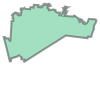

In [39]:
zipcodes.loc[0, 'geometry']

#### ...and printing it


In [40]:
print(zipcodes.loc[0, 'geometry'])

MULTIPOLYGON (((-86.970838361174 36.116443241215, -86.970838300132 36.116443152423, -86.97038032496 36.11658624569, -86.97020115443 36.116642227803, -86.969999657155 36.116705210733, -86.969704990951 36.116797311364, -86.968821465628 36.116978031538, -86.96836168311 36.116812498937, -86.968577662342 36.116087712696, -86.968545264778 36.116084032401, -86.968519329437 36.116079855511, -86.96851897803499 36.116079787364, -86.9684972753 36.116075582206, -86.968495429876 36.116075163774, -86.96849362047899 36.116074807437, -86.96847184807901 36.116069806158, -86.968450280288 36.116064172531, -86.968446028595 36.116062924662, -86.96844314765499 36.116062156842, -86.968439501685 36.116061008845, -86.968428926252 36.116057904765, -86.968407507959 36.116050936987, -86.96833531529801 36.116040252106, -86.968262750954 36.116029511788, -86.968171348797 36.116015983181, -86.96810265480801 36.116005815503, -86.96751110189101 36.115918257618, -86.96626834501301 36.115737017315, -86.966250680036 36.11

#### Plotting a GeoDataFrame is as easy as calling the GeoPandas .plot() function


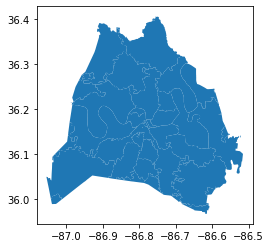

In [41]:
zipcodes.plot();

#### Add information and styling 
- set the `column =` to a column in the GeoDataFrame to color by
- change the [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) 
- pass in keywords to tweak the legend created by `matplotib`

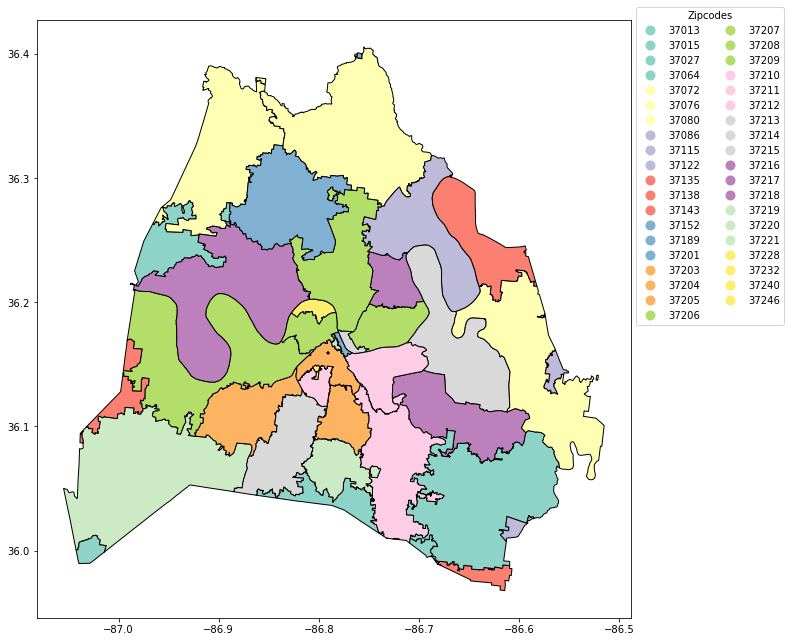

In [42]:
#geopandas handles legend styling if you pass a dict of keywords

leg_kwds = {'title': 'Zipcodes', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

zipcodes.plot(column = 'zip', figsize=(11, 11),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set3') #cmap selects a prebuilt color map from matplotlib 
plt.show()

####  read in the accidents data
- downloaded from https://data.nashville.gov/Police/Traffic-Accidents/6v6w-hpcw
- cleaned:
    - drop unwanted columns 
    - remove blank rows with no location
- print the shape 
- take a look at the first 3 rows

In [43]:
accidents = pd.read_csv('../data/Traffic_Accidents.csv') #read in the data using pandas into a dataframe called bus_stops
print(accidents.shape) #print the dataframe
accidents.head(3) #print first 3 rows

(1484, 7)


,Accident Number,ZIP,Precinct,Latitude,Longitude,Mapped Location,Illuminated
0,20210530156,37207,EAST,36.1924,-86.7727,POINT (-86.7727 36.1924),DAYLIGHT
1,20210530465,37206,EAST,36.1892,-86.7336,POINT (-86.7336 36.1892),DAYLIGHT
2,20210530857,37206,EAST,36.1916,-86.7341,POINT (-86.7341 36.1916),DAYLIGHT


In [44]:
accidents.info() #all my rows have no null values - don't know if data types will be an issue yet. Lat / Long match up to example file

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Accident Number  1484 non-null   int64  
 1   ZIP              1484 non-null   int64  
 2   Precinct         1484 non-null   object 
 3   Latitude         1484 non-null   float64
 4   Longitude        1484 non-null   float64
 5   Mapped Location  1484 non-null   object 
 6   Illuminated      1484 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 81.3+ KB


#### In order to spatially join the accidents with the zipcodes, you will need to create a GeoDataFrame of  accidents
- First create a geometry column that is a `Point` datatype - my dataset already has this

In [45]:
accidents['geometry'] = accidents.apply(lambda x: Point((x.Longitude, 
                                                         x.Latitude)), 
                                        axis=1)
accidents.head(3)
#geo data frames must have a geometry column
#geometry column here is created by applying an anonymous (throwaway function) function to the bus_stops dataframe
#function constructs points from the lat / long of each row 
accidents2 = accidents.drop('Mapped Location', 1) #dropping mapped locations to reduce confusion, creating new df to maintain old one
accidents2.head()

C:\Users\mdeca\AppData\Local\Temp\ipykernel_16304\1824632658.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  accidents2 = accidents.drop('Mapped Location', 1) #dropping mapped locations to reduce confusion, creating new df to maintain old one


,Accident Number,ZIP,Precinct,Latitude,Longitude,Illuminated,geometry
0,20210530156,37207,EAST,36.1924,-86.7727,DAYLIGHT,POINT (-86.7727 36.1924)
1,20210530465,37206,EAST,36.1892,-86.7336,DAYLIGHT,POINT (-86.7336 36.1892)
2,20210530857,37206,EAST,36.1916,-86.7341,DAYLIGHT,POINT (-86.7341 36.1916)
3,20210528464,37206,EAST,36.1676,-86.7622,DARK - LIGHTED,POINT (-86.76220000000001 36.1676)
4,20210530004,37207,EAST,36.2063,-86.7735,DARK - NOT LIGHTED,POINT (-86.7735 36.2063)


#### Now that the accidents data has a geometry field, you can use it to build a GeoDataFrame 
- you want the CRS for the accidents to match the CRS in the zipcodes GeoDataFrame 


In [46]:
zipcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### The `GeoDataFrame()` constructor needs 3 parameters:
 - a DataFrame
 - a coordinate reference system
 - a geometry

In [47]:
accidents_geo = gpd.GeoDataFrame(accidents2, #create new geodf called accidents_geo
                           crs = zipcodes.crs, #use crs from zipcodes
                           geometry = accidents2['geometry']) #define geometry using geometry column from accidents

In [48]:
type(accidents_geo)

geopandas.geodataframe.GeoDataFrame

#### Now you are ready to combine bus stops and zipcodes with a spatial join
- first a little clean up for the zipcodes
    - just keep the zip, po_name, and geometry columns
- then construct the join 
    - keep in mind that you want to find the bus stops within a zip code polygon
    - the geometry for the new (combined) GeoDataFrame comes from the left GeoDataFrame


In [49]:
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]

In [50]:
accidents_by_zip = gpd.sjoin(accidents_geo, zipcodes, op = 'within') #accidents that are within zipcodes

In [51]:
accidents_by_zip.info() #this is equal to the # of rows in accidents with no nulls... hoping that's a good sign

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1484 entries, 0 to 1335
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Accident Number  1484 non-null   int64   
 1   ZIP              1484 non-null   int64   
 2   Precinct         1484 non-null   object  
 3   Latitude         1484 non-null   float64 
 4   Longitude        1484 non-null   float64 
 5   Illuminated      1484 non-null   object  
 6   geometry         1484 non-null   geometry
 7   index_right      1484 non-null   int64   
 8   zip              1484 non-null   object  
 9   po_name          1484 non-null   object  
dtypes: float64(2), geometry(1), int64(3), object(4)
memory usage: 127.5+ KB


#### Now that the data is joined spatially you can count the accidents by zip code  and see how many are within each polygon 
- using the `value_counts()` method


In [52]:
accidents_by_zip['zip'].value_counts() #used bracket notation instead of dot notation in this instance because column zip is the same name as a zip method
#I also have two "Zip" columns - this uses 'zip' from the zipcodes file

37207    649
37206    551
37216    242
37213     36
37208      3
37211      1
37203      1
37115      1
Name: zip, dtype: int64

#### Let's take a closer look at the 551 accidents in the 37206 zip code #people drive the worst here... so this is not a surprise
- filter the accidents_by_zip data to just get accidents in 37206
- filter the zip code geodataframe to just the polygon (row) for 37206


In [95]:
accidents_in_37206 = accidents_by_zip.loc[(accidents_by_zip['zip']== '37206') & (accidents_by_zip['Illuminated'] == 'DAYLIGHT')]
 #filter the previous step to only zipcode 37206, name it "accidents_in_37206"
accidents_in_37206.shape #this shows the number of rows and columns in the dataframe

(374, 10)

In [96]:
polygon37206 = zipcodes.loc[zipcodes['zip'] == '37206'] #do the same thing to the zipcodes
polygon37206.shape

(1, 3)

#### Now plot these two together
- first plot the polygons for 37206 and make them anything but light green
- next plot the points for the accidents and color them by illumination type

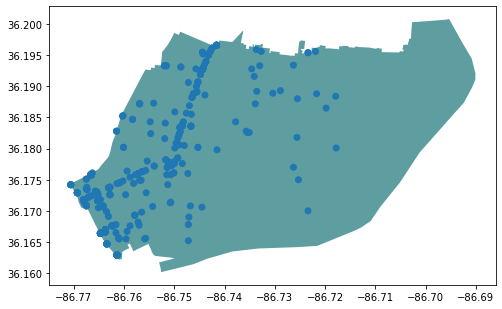

In [97]:
#fig, ax = matplotlib.subplots()
ax = polygon37206.plot(figsize = (8, 10), color = 'cadetblue') #figsize inputs are width, height in inches
accidents_in_37206.plot( ax = ax, column = 'Illuminated');
plt.show(); #fig defines total plotting area, ax defines individual plots

#### We're getting there! It would be helpful to have streets, though wouldn't it? We can add a street map with the folium package.

#### folium maps require a center point for the street map. 
- Make use of a GeoSeries attribute (.centroid) which gives the center of a polygon
- Since there are two polygons which should we use?

In [98]:
polygon37206.geometry.centroid #finds the center of both polygons for the folium map 

C:\Users\mdeca\AppData\Local\Temp\ipykernel_16304\1844949022.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon37206.geometry.centroid #finds the center of both polygons for the folium map


26    POINT (-86.73098 36.18090)
dtype: geometry

In [99]:
#find the center of the larger (more southern) polygon and look at it by using [26] from above 
center = polygon37206.geometry.centroid[26]
print(center) #this gives us the center long as x, lat as y

POINT (-86.7309830626016 36.1808969092208)


C:\Users\mdeca\AppData\Local\Temp\ipykernel_16304\1763416095.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = polygon37206.geometry.centroid[26]


#### Folium requires a location point as an array 
- with *latitude* first
- but shapely Points have *longitude* first 

In [100]:
# reverse the order when constructing the array for folium location
#use center from earlier which is in long (x) / lat (y) and reverse it
area_center = [center.y, center.x] #using square brackets creates array. creates comma separated coordinates by reversing the lat / long points

# check the order of area_center, the location for our folium map
print(area_center)

[36.1808969092208, -86.7309830626016]


#### To create a folium map just call the folium `Map()` constructor
- `location` is the only argument required by the constructor
    - Set `area_center` as the `location` of the folium map. 
- `zoom_start` is an optional argument 
    - A setting of 12 should get us nice and close

In [101]:
#create our map of Nashville Zip Code 37206 and show it
map_37206 = folium.Map(location =  area_center, zoom_start = 13) #use the central point created with variable area_center
#create the map and define zoom level. Zoom start requires integer, not float. Default is 10. Higher = more zoomed in
map_37206

###### Next, let's add our 37206 polygon and markers for accidents 

#### `itterows()` is a generator that iterates through the rows of a DataFrame and returns a tuple with the row id and row values. 
- Below, we are printing the row values for the first 3 row as we iterate through the GeoDataFrame of accidents in 37206

In [102]:
i = 0
for row_index, row_values in accidents_in_37206.iterrows(): #iterates through each row of the accidents_in_37206 dataframe
    if i <3: # i = row number , so if row number is less than 3, then...
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

index is 1
values are:
 
Accident Number                 20210530465
ZIP                                   37206
Precinct                               EAST
Latitude                            36.1892
Longitude                          -86.7336
Illuminated                        DAYLIGHT
geometry           POINT (-86.7336 36.1892)
index_right                              26
zip                                   37206
po_name                           NASHVILLE
Name: 1, dtype: object
------------------------- 
index is 2
values are:
 
Accident Number                 20210530857
ZIP                                   37206
Precinct                               EAST
Latitude                            36.1916
Longitude                          -86.7341
Illuminated                        DAYLIGHT
geometry           POINT (-86.7341 36.1916)
index_right                              26
zip                                   37206
po_name                           NASHVILLE
Name: 2, dtype: obje

#### Create map_37206 again with additional features:
- add the zipcode area outline (polygon_37206)
- iterate through the accidents_in_37206 to
    - create location from each lat and lng
    - create a popup from the stop column
    - create a custom icon if you want with [font-awesome](https://fontawesome.com/v4.7.0/icons/)
    - build a marker from each location and popup and (optionally) your custom icon 
    - add the marker to  `map_37206`
- display `map_37206`

In [103]:
#draw our zip code area: 37206
map_37206 = folium.Map(location =  area_center, zoom_start = 14)

folium.GeoJson(polygon37206).add_to(map_37206)

#iterate through accidents_in_37206 to create locations and markers 
#for each accident
#remember for Folium locations, lat is listed first!!

for row_index, row_values in accidents_in_37206.iterrows(): 
    loc = [row_values['Latitude'], row_values['Longitude']] #grabs values from the data frame in the latitude and longtitude columns, 
    #separated by a comma. Creates an array for each lat/long set. 
    pop = str('Lighting: '+row_values['Illuminated']) #defines the popup message as a string of the illumination type
    icon=folium.Icon(color="darkred",icon="exclamation-circle",prefix='fa') # defines the icon type 
    
    marker = folium.Marker(
        location = loc, 
        popup = pop, icon = icon) #tells folium where to place the markers. Use the location from the iteration, defines the popup and icon

    marker.add_to(map_37206)
map_37206.save('../maps/map37206.html') #adds the markers to the map

#display our map
map_37206

##I'm not completing these last 2 steps because I don't want clusters

#### If you have a lot of markers, you might want to use marker clusters
- Folium has `MarkerCluster()` and `FastMarkerCluster()`
- Construct a `MarkerCluster()` 
    - construct a `MarkerCluster()` and `.add_to()` the map
    - when you loop through the data and create markers add those to the marker cluster
- Construct a `FastMarkerCluster()` by passing a list of locations

#### You can save your map as an html file and it will retain the interactive qualities

folium.Map? 

cluster_map_37207 = folium.Map(location =  area_center, zoom_start = 12)

#create a marker cluster
marker_cluster = MarkerCluster().add_to(cluster_map_37207)

folium.GeoJson(polygon37207).add_to(cluster_map_37207)

# inside the loop add each marker to the cluster
for row_index, row_values in stops_in_37207.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['route'])
    icon=folium.Icon(color="blue",icon="bus", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)

    
#save an interactive HTML map by calling .save()
cluster_map_37207.save('../maps/cluster37207.html')

cluster_map_37207  

#draw our zip code area: 37207
map_37207 = folium.Map(location =  area_center, zoom_start = 12)

folium.GeoJson(polygon37207).add_to(map_37207)

#create a list of locations and pass them to FastMarkerCluster()
locations = stops_in_37207[['lat', 'lng']].values.tolist()
map_37207.add_child(
    FastMarkerCluster(locations)
)



#display our map
map_37207